In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


In [ ]:
# !pip install tensorflow scikit-learn imbalanced-learn plotly lightgbm xgboost catboost
#!pip install tabulate
#!pip install --upgrade pandas

import warnings
import time

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine learning libraries
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, StackingClassifier)  # Added StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, make_scorer)
from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV)
from sklearn.naive_bayes import (BernoulliNB, GaussianNB)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from scipy.stats import randint, uniform
from tabulate import tabulate
from collections import Counter

# Suppress warnings
warnings.filterwarnings('ignore')



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Read in dataset
df = pd.read_csv('/content/Fraudulent_E-Commerce_Transaction_Data_2.csv')
print(f"Number of observations in original dataset: {len(df)}")

# Seperate dataset into train-test split
y = df['Is Fraudulent']
X = df.drop('Is Fraudulent', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Create validation set from training set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"Number of observations in training dataset: {len(X_train)}")
print(f"Number of observations in testing dataset: {len(X_test)}")
print(f"Number of observations in validation dataset: {len(X_val)}")

Number of observations in original dataset: 23634
Number of observations in training dataset: 17016
Number of observations in testing dataset: 2364
Number of observations in validation dataset: 4254


# EDA on Training Dataset

In [ ]:
train_df = X_train.copy()
train_df['Is Fraudulent'] = y_train

# Peek at training dataset
train_df.head()


,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Account Age Days,Transaction Hour,Is Fraudulent
5609,2cf1c2f8-84db-44fb-aa6f-815304d63aeb,2d9a4a53-76e9-4372-811e-034daefd380d,422.74,2024-03-14 06:17:14,credit card,toys & games,3,22,South Sarah,tablet,135.190.43.175,"6263 Turner Coves Apt. 167\nMelissamouth, GA 5...","6263 Turner Coves Apt. 167\nMelissamouth, GA 5...",112,6,0
12269,06322848-e66f-410b-bf83-f2df5574c5d0,87320ada-da14-4a3f-9bac-88148f4df04a,32.29,2024-01-19 22:20:29,debit card,toys & games,5,27,New Paul,desktop,61.164.68.237,"111 Hobbs Cove\nWest Maxfurt, MA 16967","28340 Webb Key Suite 421\nFigueroachester, OR ...",293,22,0
19102,edc284a9-7ef7-4391-9331-4415486040de,9f585883-6d0f-4e3c-b7b5-7137ebf0ba2b,175.88,2024-01-11 07:47:16,bank transfer,toys & games,1,48,Port Terrancefort,mobile,205.29.6.208,USNS Savage\nFPO AA 36278,USNS Savage\nFPO AA 36278,55,7,0
8143,bbb2b25c-0bd1-4f39-b3df-b4ab6405657c,7eaa21ac-ff85-46eb-b84f-2269d1e1232c,48.15,2024-03-01 20:46:02,bank transfer,electronics,2,46,Tinafurt,mobile,25.32.207.146,2343 Leonard Branch Apt. 184\nLake Jaredcheste...,2343 Leonard Branch Apt. 184\nLake Jaredcheste...,184,20,0
15391,badc406a-acbd-4129-b539-902db371456b,c8c2c75f-1755-479d-8327-cdfc6c3f4cfb,110.65,2024-01-05 21:33:29,PayPal,health & beauty,5,41,East Victoriamouth,mobile,191.244.55.156,"46843 Lyons Roads\nBrandonmouth, WY 22805","46843 Lyons Roads\nBrandonmouth, WY 22805",251,21,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17016 entries, 5609 to 1827
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction ID      17016 non-null  object 
 1   Customer ID         17016 non-null  object 
 2   Transaction Amount  17016 non-null  float64
 3   Transaction Date    17016 non-null  object 
 4   Payment Method      17016 non-null  object 
 5   Product Category    17016 non-null  object 
 6   Quantity            17016 non-null  int64  
 7   Customer Age        17016 non-null  int64  
 8   Customer Location   17016 non-null  object 
 9   Device Used         17016 non-null  object 
 10  IP Address          17016 non-null  object 
 11  Shipping Address    17016 non-null  object 
 12  Billing Address     17016 non-null  object 
 13  Account Age Days    17016 non-null  int64  
 14  Transaction Hour    17016 non-null  int64  
 15  Is Fraudulent       17016 non-null  int64  
dtypes: floa

In [ ]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Transaction Amount,17016.0,228.385595,278.435044,10.0,68.48,151.515,295.1625,5725.0
Quantity,17016.0,3.001704,1.421777,1.0,2.00,3.000,4.0000,5.0
Customer Age,17016.0,34.532558,10.036917,-2.0,28.00,35.000,41.0000,73.0
Account Age Days,17016.0,179.752938,107.367014,1.0,86.00,180.000,274.0000,365.0
Transaction Hour,17016.0,11.317760,6.976123,0.0,5.00,11.000,17.0000,23.0
Is Fraudulent,17016.0,0.051716,0.221460,0.0,0.00,0.000,0.0000,1.0


Non-Fraudulent (Is Fraudulent = 0): 16136
Fraudulent (Is Fraudulent = 1): 880
Non-Fraudulent (Is Fraudulent = 0): 94.83%
Fraudulent (Is Fraudulent = 1): 5.17%


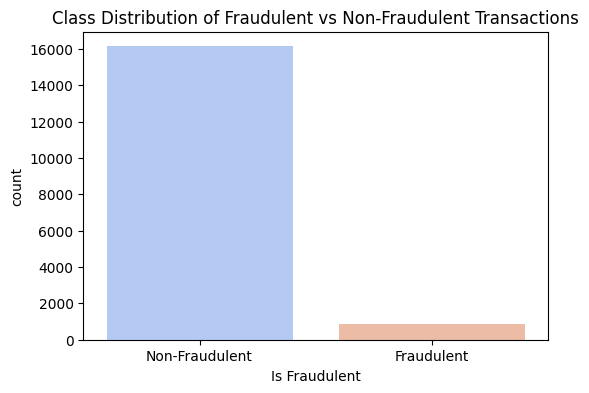

In [ ]:
# Count of Fraudulent instances
fraud_counts = train_df['Is Fraudulent'].value_counts()

# Display the count of each instance
print("Non-Fraudulent (Is Fraudulent = 0):", fraud_counts[0])
print("Fraudulent (Is Fraudulent = 1):", fraud_counts[1])

# Proportion of each class
fraud_proportion = train_df['Is Fraudulent'].value_counts(normalize=True) * 100
print("Non-Fraudulent (Is Fraudulent = 0): {:.2f}%".format(fraud_proportion[0]))
print("Fraudulent (Is Fraudulent = 1): {:.2f}%".format(fraud_proportion[1]))

# Distribution of fraudulent vs non-fraudulent transactions
plt.figure(figsize=(6, 4))
sns.countplot(x='Is Fraudulent', data=train_df, palette='coolwarm')
plt.title('Class Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])
plt.show()


In [ ]:
# Check for missing values
print("\nMissing Values:")
print(train_df.isnull().sum())


Missing Values:
Transaction ID        0
Customer ID           0
Transaction Amount    0
Transaction Date      0
Payment Method        0
Product Category      0
Quantity              0
Customer Age          0
Customer Location     0
Device Used           0
IP Address            0
Shipping Address      0
Billing Address       0
Account Age Days      0
Transaction Hour      0
Is Fraudulent         0
dtype: int64


In [ ]:
#Check for duplicate rows
print("\nDuplicate Rows:")
print(train_df.duplicated().sum())


Duplicate Rows:
0


In [ ]:
#Categorical variables summary
print("\nCategorical Variables Summary:")
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns
print(train_df[categorical_cols].nunique())


Categorical Variables Summary:
Transaction ID       17016
Customer ID          17016
Transaction Date     17005
Payment Method           4
Product Category         5
Customer Location    11661
Device Used              3
IP Address           17016
Shipping Address     17016
Billing Address      17016
dtype: int64


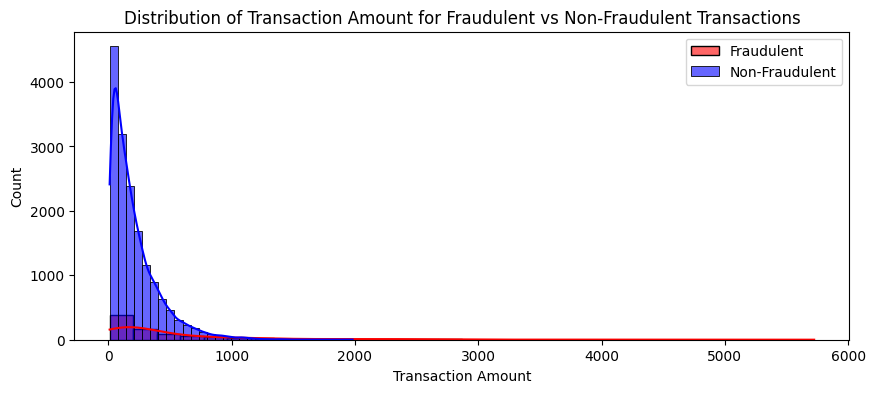

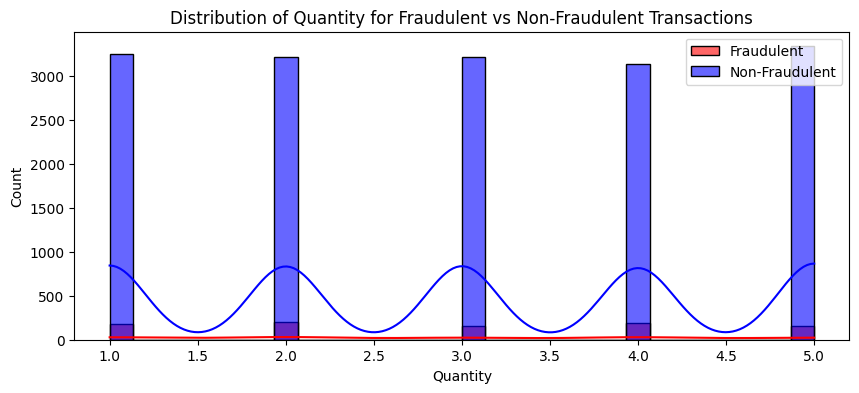

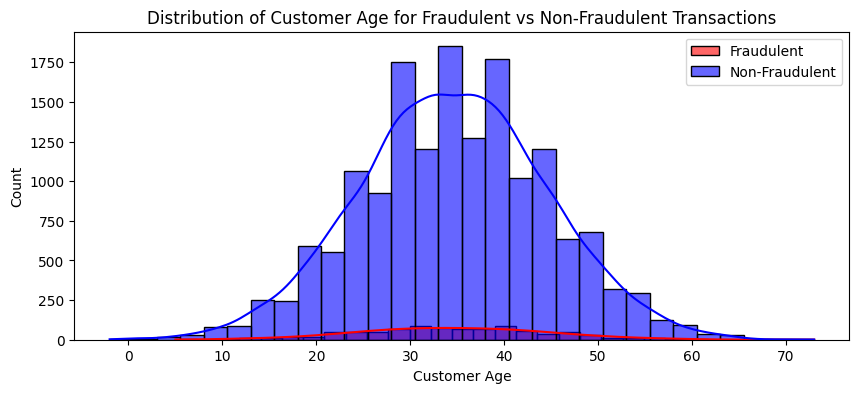

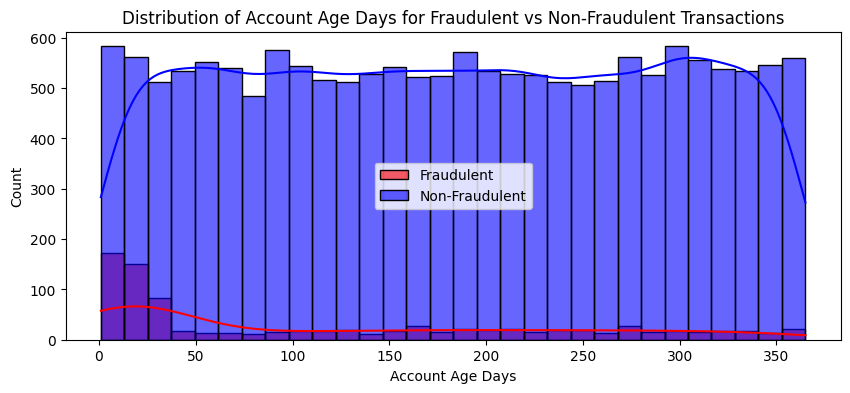

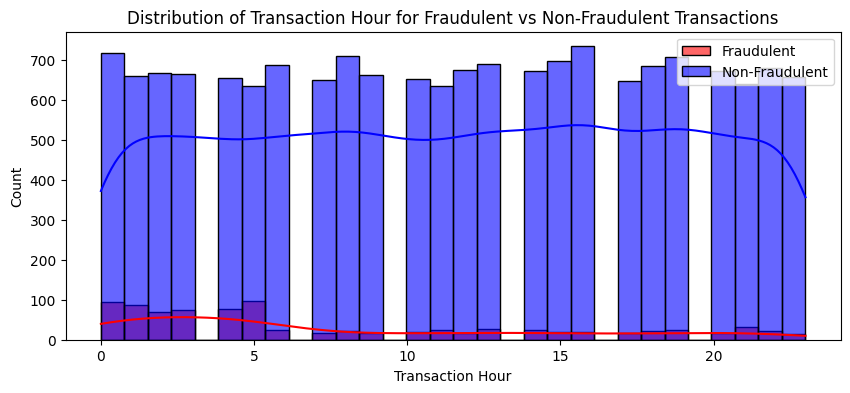

In [ ]:
# Get list of numerical columns
numerical_cols = ['Transaction Amount', 'Quantity', 'Customer Age','Account Age Days', 'Transaction Hour']

# Plot distributions of each numerical feature for Fraudulent vs Non-Fraudulent transactions
for col in numerical_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(train_df[train_df['Is Fraudulent'] == 1][col], color='red', label='Fraudulent', kde=True, bins=30, alpha=0.6)
    sns.histplot(train_df[train_df['Is Fraudulent'] == 0][col], color='blue', label='Non-Fraudulent', kde=True, bins=30, alpha=0.6)
    plt.title(f'Distribution of {col} for Fraudulent vs Non-Fraudulent Transactions')
    plt.legend()
    plt.show()


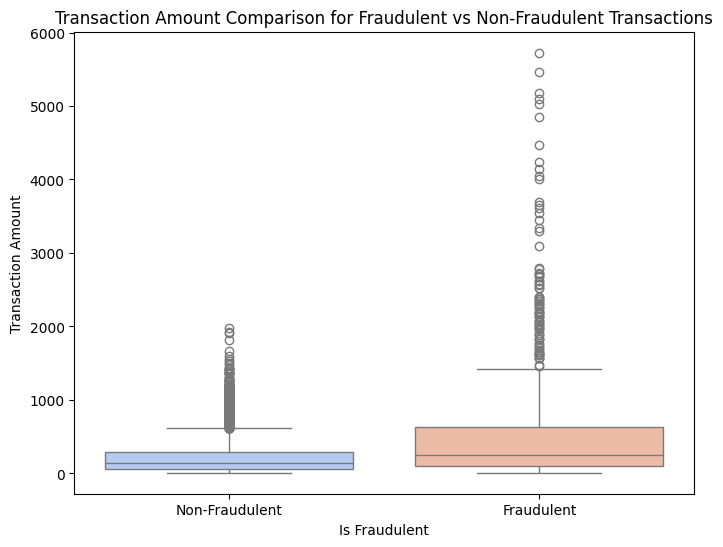

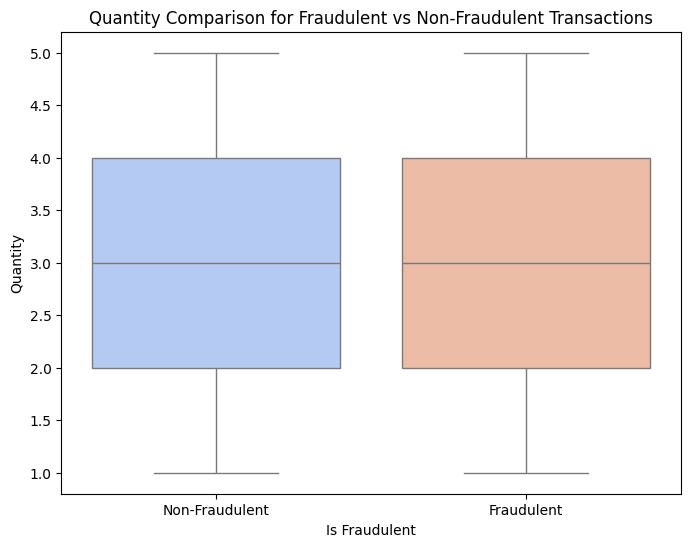

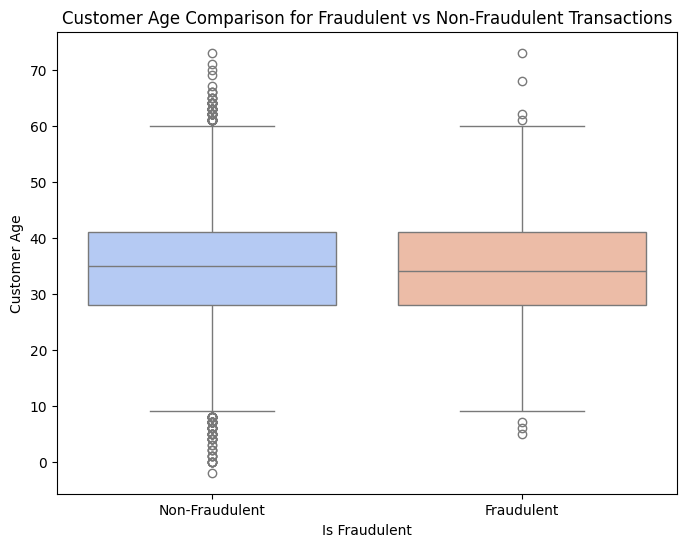

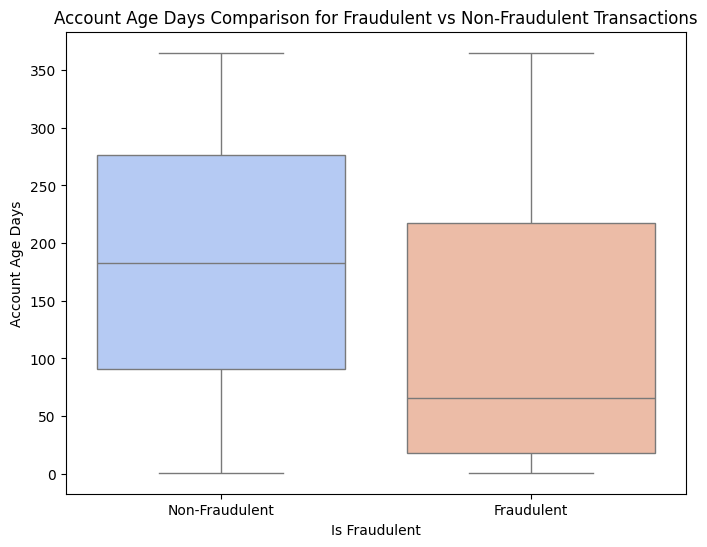

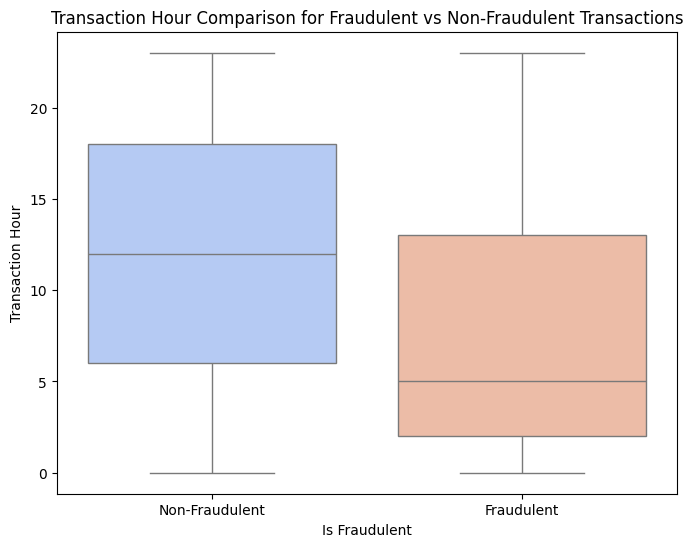

In [ ]:
# Box plot for numerical features to compare Fraudulent vs Non-Fraudulent transactions
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Is Fraudulent', y=col, data=train_df, palette='coolwarm')
    plt.title(f'{col} Comparison for Fraudulent vs Non-Fraudulent Transactions')
    plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])
    plt.show()


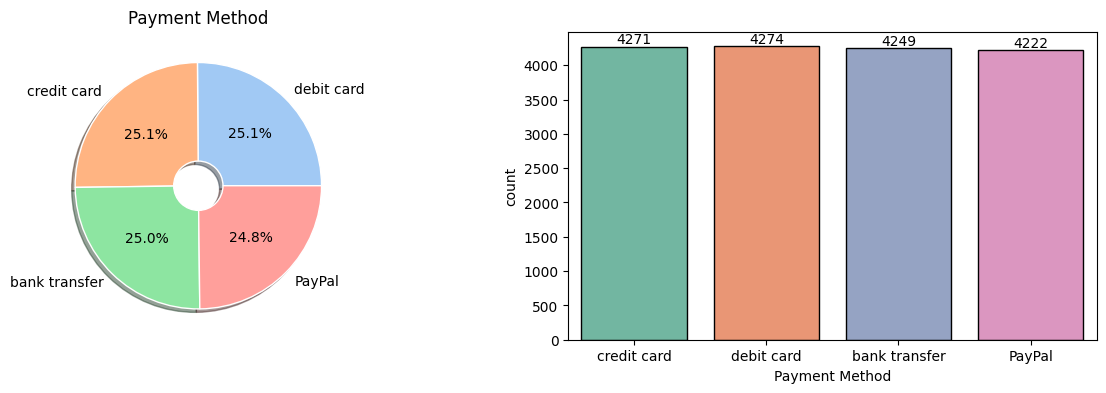

In [ ]:
payment_count = train_df["Payment Method"].value_counts()
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.set_palette('pastel')
colors = sns.color_palette()
plt.pie(payment_count,labels = payment_count.index,shadow=True,autopct='%1.1f%%',
        colors=colors,
        wedgeprops=dict(width=0.8,edgecolor="w"))
plt.title("Payment Method")

plt.subplot(1,2,2)

ax = sns.countplot(data=train_df,x="Payment Method",edgecolor="black",linewidth=1, palette="Set2")
for container in ax.containers:
    ax.bar_label(container)

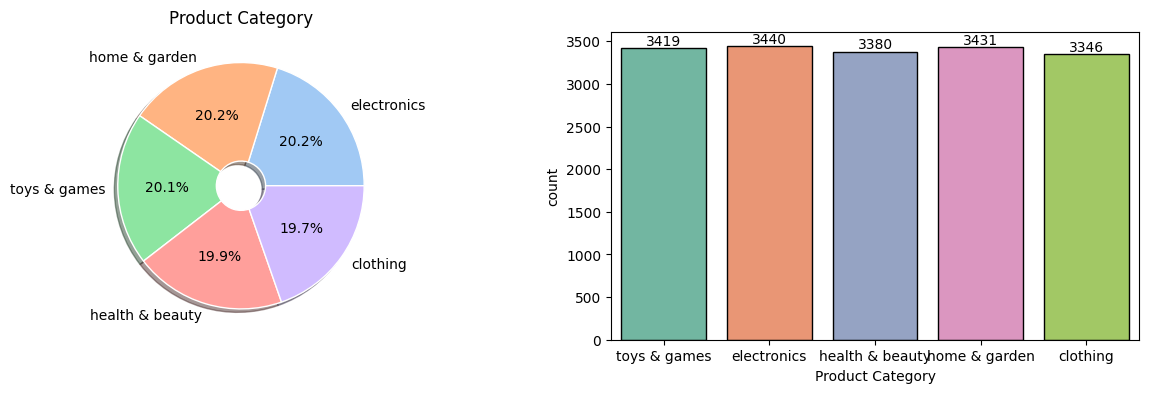

In [ ]:
category_count = train_df["Product Category"].value_counts()
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.set_palette('pastel')
colors = sns.color_palette()
plt.pie(category_count,labels = category_count.index,shadow=True,autopct='%1.1f%%',
        colors=colors,
        wedgeprops=dict(width=0.8,edgecolor="w"))
plt.title("Product Category")

plt.subplot(1,2,2)

ax = sns.countplot(data=train_df,x="Product Category",edgecolor="black",linewidth=1, palette="Set2")
for container in ax.containers:
    ax.bar_label(container)

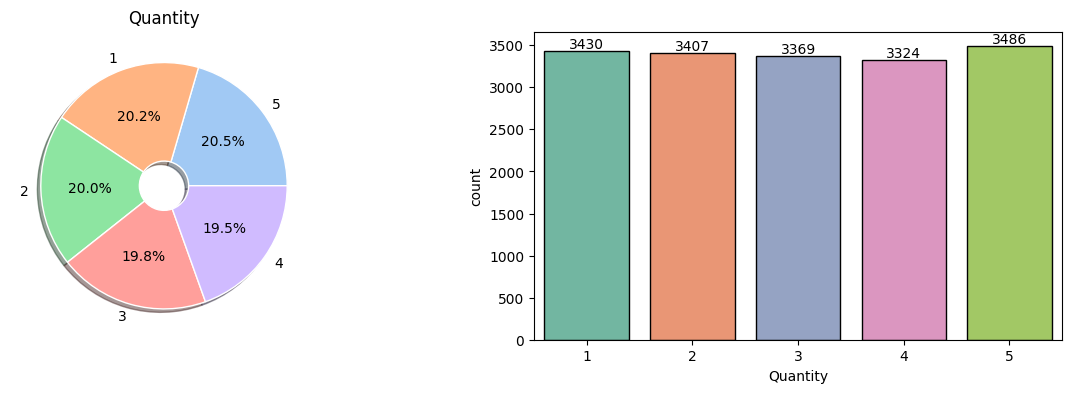

In [ ]:
quantity_count = train_df["Quantity"].value_counts()
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.set_palette('pastel')
colors = sns.color_palette()
plt.pie(quantity_count,labels = quantity_count.index,shadow=True,autopct='%1.1f%%',
        colors=colors,
        wedgeprops=dict(width=0.8,edgecolor="w"))
plt.title("Quantity")

plt.subplot(1,2,2)

ax = sns.countplot(data=train_df,x="Quantity",edgecolor="black",linewidth=1, palette="Set2")
for container in ax.containers:
    ax.bar_label(container)

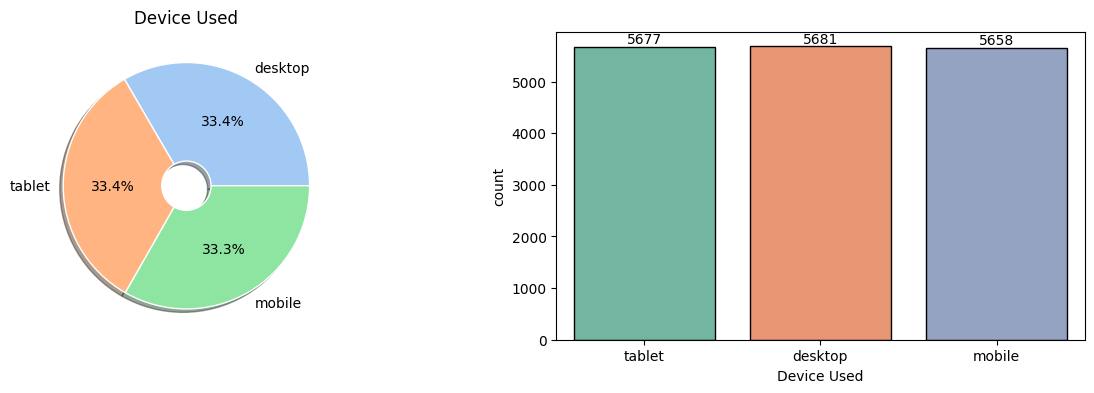

In [ ]:
device_count = train_df["Device Used"].value_counts()
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.set_palette('pastel')
colors = sns.color_palette()
plt.pie(device_count,labels = device_count.index,shadow=True,autopct='%1.1f%%',
        colors=colors,
        wedgeprops=dict(width=0.8,edgecolor="w"))
plt.title("Device Used")

plt.subplot(1,2,2)

ax = sns.countplot(data=train_df,x="Device Used",edgecolor="black",linewidth=1, palette="Set2")
for container in ax.containers:
    ax.bar_label(container)

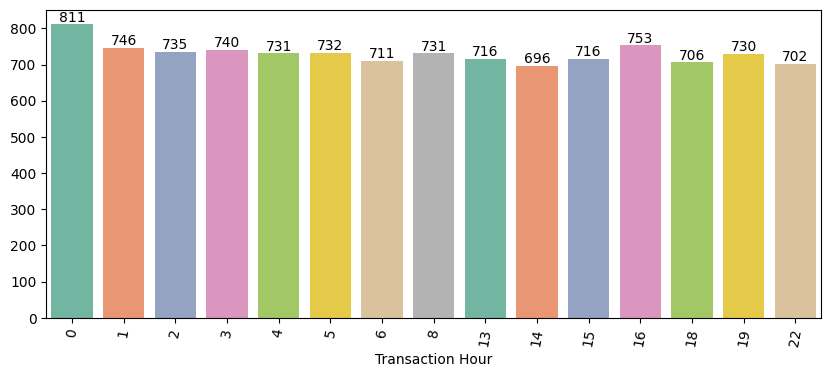

In [ ]:
hour_count = train_df["Transaction Hour"].value_counts().head(15)

plt.figure(figsize=(10,4))
sns.set_palette('Set2')
colors = sns.color_palette()
ax=sns.barplot(x=hour_count.index, y=hour_count.values,palette=colors)
plt.xticks(rotation=80)
for container in ax.containers:
    ax.bar_label(container)
plt.show()

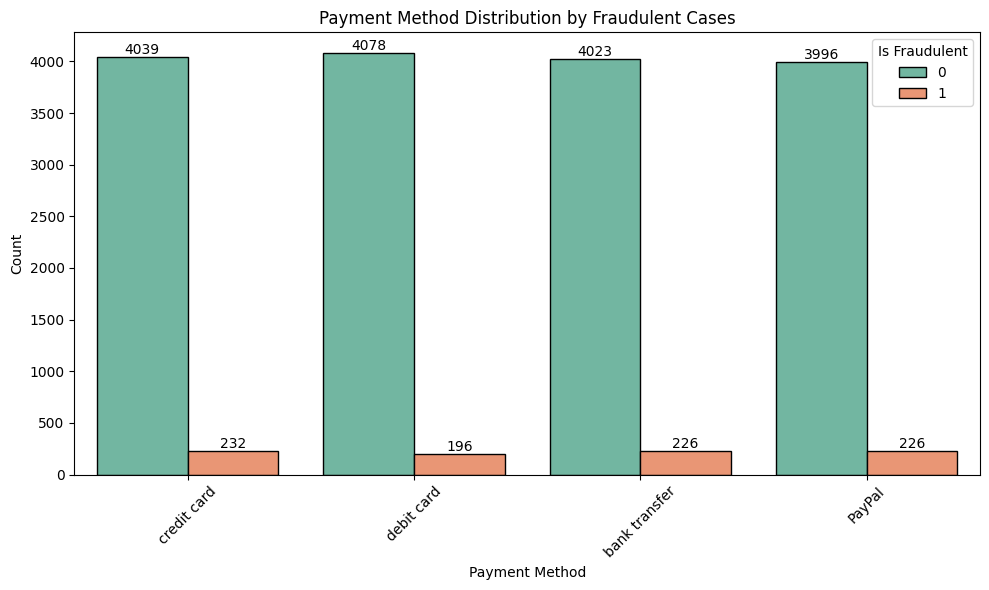

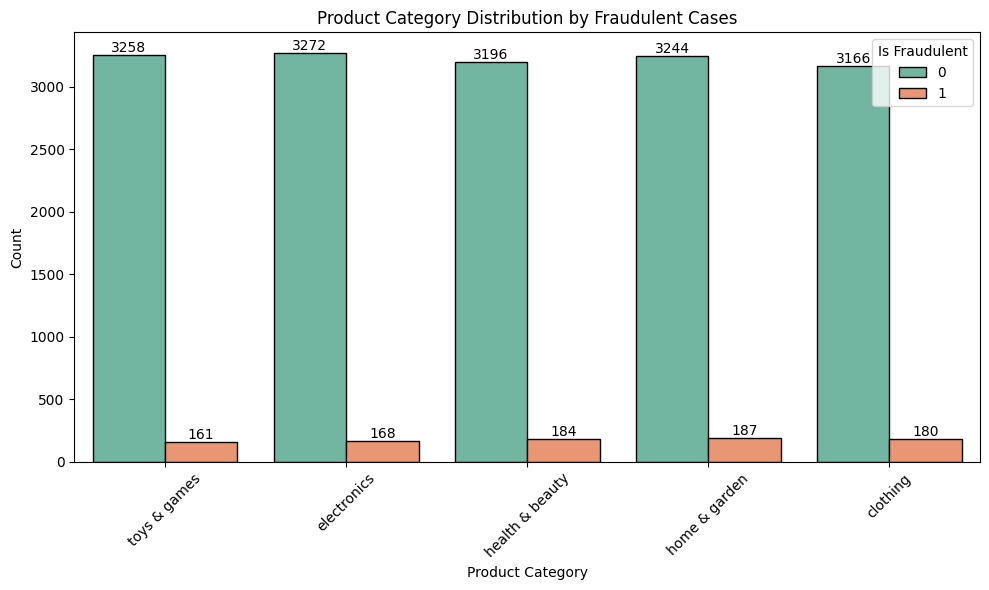

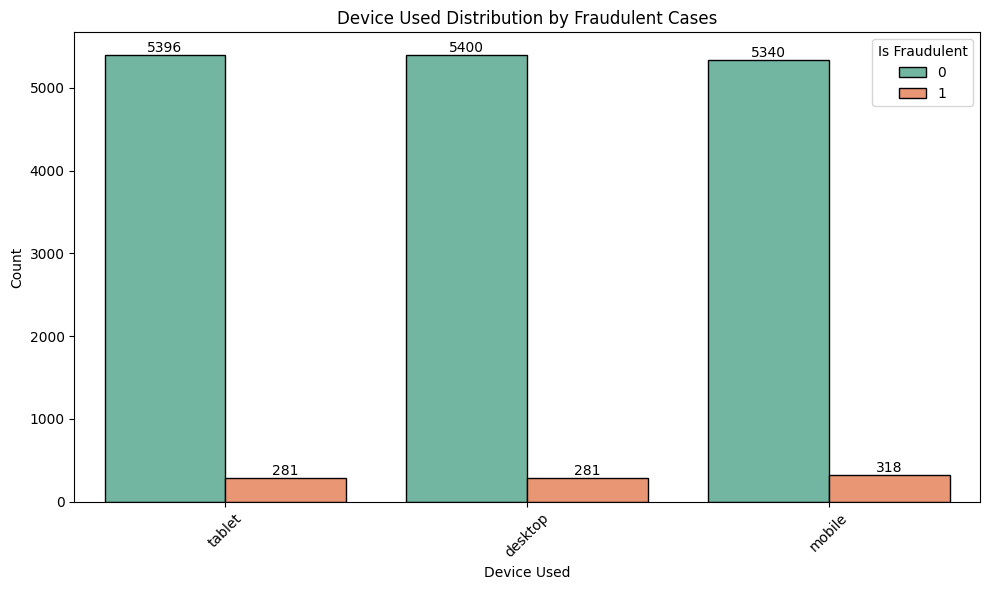

In [ ]:
selected_features = ['Payment Method', 'Product Category', 'Device Used']

# Plot comparisons
for feature in selected_features:
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=train_df, x=feature, hue='Is Fraudulent', edgecolor="black", palette="Set2")
    plt.title(f'{feature} Distribution by Fraudulent Cases')
    plt.xlabel(feature)
    plt.ylabel('Count')

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Adding bar labels for counts
    for container in ax.containers:
        ax.bar_label(container)

    plt.tight_layout()
    plt.show()

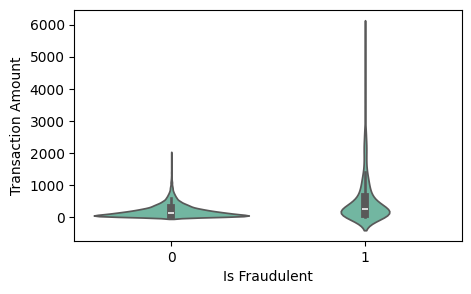

In [ ]:
plt.figure(figsize=(5, 3))
sns.violinplot(data=train_df, x='Is Fraudulent', y='Transaction Amount')
plt.show()



# Data Preparation

## Feature Engineering

In [ ]:
def create_new_features(df) -> pd.DataFrame:
    """
    Create new features for an existing dataset
    """
    df = df.copy()

    # 1. Handle dates
    df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
    df['Transaction Day'] = df['Transaction Date'].dt.day
    df['Transaction Month'] = df['Transaction Date'].dt.month

    # 2. Create address match features
    df['Address Match'] = (df['Shipping Address'] ==
                                   df['Billing Address']).astype(int)

    # 3. Extract IP information (first octet for geolocation)
    df['IP First Octet'] = df['IP Address'].apply(
        lambda x: int(str(x).split('.')[0]))

    # 4. Create transaction amount features
    df['Amount Per Item'] = df['Transaction Amount'] / df['Quantity']

    return df


In [ ]:
def encode_cyclical_features(df):
    """
    Encode cyclical features using sine and cosine transformations to capture time relationships
    """
    df = df.copy()

    # Hour encoding (24-hour cycle)
    df['Hour_Sin'] = np.sin(2 * np.pi * df['Transaction Hour']/24)
    df['Hour_Cos'] = np.cos(2 * np.pi * df['Transaction Hour']/24)

    # Day encoding (31-day cycle)
    df['Day_Sin'] = np.sin(2 * np.pi * df['Transaction Day']/31)
    df['Day_Cos'] = np.cos(2 * np.pi * df['Transaction Day']/31)

    # Month encoding (12-month cycle)
    df['Month_Sin'] = np.sin(2 * np.pi * df['Transaction Month']/12)
    df['Month_Cos'] = np.cos(2 * np.pi * df['Transaction Month']/12)

    # Drop original cyclical features
    df.drop(['Transaction Hour', 'Transaction Day', 'Transaction Month'], axis=1, inplace=True)

    return df

In [ ]:
def clean_and_format_data(df, encoder=None, scaler=None, is_training=True, mean_age=0) -> pd.DataFrame:
    """
    Cleans dataset by scaling numerical columns, one-hot encoding categorical
    columns and dealing with unlikely values
    """
    df = df.copy()
    categorical_columns = ['Payment Method', 'Product Category', 'Device Used']
    numerical_features = ['Transaction Amount', 'Quantity', 'Customer Age',
                         'Account Age Days', 'Amount Per Item']

    # One hot encode categorical columns
    if is_training:
        # If training dataset, create new encoder
        encoder = {}
        for column in categorical_columns:
            dummies = pd.get_dummies(df[column], prefix=column, drop_first=True)
            # Store column names for test data
            encoder[column] = dummies.columns
            df = pd.concat([df, dummies], axis=1)
    else:
        # If test dataset, use existing encoder
        if encoder is None:
            raise ValueError("Encoder must be provided for test data")
        for column in categorical_columns:
            dummies = pd.get_dummies(df[column], prefix=column)
            # Make sure we have the same columns as training
            for col in encoder[column]:
                if col not in dummies.columns:
                    dummies[col] = 0
            # Keep only the columns that were in training
            dummies = dummies[encoder[column]]
            df = pd.concat([df, dummies], axis=1)

    # Drop original categorical columns
    df.drop(columns=categorical_columns, inplace=True)

    # Fix Customer Column
    '''
    The lower fence of the customer age is 9. We will replace values between -9 and 8 with the mean,
    and values less than -9 will be replaced with their absolute values.
    '''
    if is_training:
      mean_age = np.round(df['Customer Age'].mean(),0)
    elif mean_age is None:
      raise ValueError("mean_age must be provided for test data")

    df['Customer Age'] = np.where(df['Customer Age'] < 9,
                                    mean_age,
                                    df['Customer Age'])

    # Scale numerical features
    if is_training:
        # If training data, fit and transform
        scaler = StandardScaler()
        df[numerical_features] = scaler.fit_transform(df[numerical_features])
    else:
        # If test data, just transform
        if scaler is None:
            raise ValueError("Scaler must be provided for test data")
        df[numerical_features] = scaler.transform(df[numerical_features])


    return df, encoder, scaler, mean_age


In [ ]:
def preprocess_data(df, encoder=None, scaler=None, is_training=True, mean_age=0):
    """
    Preprocess the fraud detection dataset
    """
    # Create a copy to avoid modifying original data
    df_processed = df.copy()

    # 1. Create new features
    df_processed = create_new_features(df_processed)

    # 2. Clean and format dataset
    df_processed, encoder, scaler, mean_age = clean_and_format_data(
        df_processed, encoder, scaler, is_training, mean_age
    )

    # 3. Drop irrelevant columns
    df_processed.drop(columns=["Transaction ID", "Customer ID", "Customer Location",
                     "IP Address", "Transaction Date","Shipping Address","Billing Address"], inplace=True)

    # 4. Drop rows with NaN values
    df_processed = df_processed.dropna()

    # 5. Encode cyclical features
    df_processed = encode_cyclical_features(df_processed)

    return df_processed, encoder, scaler, mean_age

In [ ]:
# For training data
X_train, encoder, scaler, mean_age = preprocess_data(X_train, is_training=True)

# For validation data
X_val, _, _, _ = preprocess_data(
    X_val,
    encoder=encoder,
    scaler=scaler,
    is_training=False,
    mean_age=mean_age
)

# For test data
X_test, _, _, _ = preprocess_data(
    X_test,
    encoder=encoder,
    scaler=scaler,
    is_training=False,
    mean_age=mean_age
)

## Resampling

In [ ]:
def balance_dataset(X, y, majority_ratio, final_ratio):
    n_minority = Counter(y)[1]  # number of fraudulent cases
    n_majority = n_minority * majority_ratio  # desired majority cases

    print(f"\nUndersampling majority class to {majority_ratio}:1 ratio")
    print(f"Target majority class samples: {n_majority}")

    # Step 1: Undersample
    undersampler = RandomUnderSampler(
        sampling_strategy={0: n_majority},
        random_state=42
    )
    X_under, y_under = undersampler.fit_resample(X, y)

    print("Distribution after undersampling:")
    print(Counter(y_under))

    # Step 2: SMOTE
    print(f"\nApplying SMOTE to achieve {final_ratio}:1 ratio")
    smote = SMOTE(sampling_strategy={1: n_majority//final_ratio}, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_under, y_under)

    print("Final distribution:")
    print(Counter(y_resampled))

    return X_resampled, y_resampled

In [ ]:
# Get a balanced training dataset
X_train, y_train = balance_dataset(
    X_train, y_train,
    majority_ratio=5,  # First undersample to 5:1
    final_ratio=2      # Then SMOTE to 2:1
)


Undersampling majority class to 5:1 ratio
Target majority class samples: 4400
Distribution after undersampling:
Counter({0: 4400, 1: 880})

Applying SMOTE to achieve 2:1 ratio
Final distribution:
Counter({0: 4400, 1: 2200})


# Model Building

## Baseline Model - Logistic Regression


--- Threshold = 0.5 ---
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      4034
           1       0.19      0.39      0.26       220

    accuracy                           0.88      4254
   macro avg       0.58      0.65      0.60      4254
weighted avg       0.92      0.88      0.90      4254



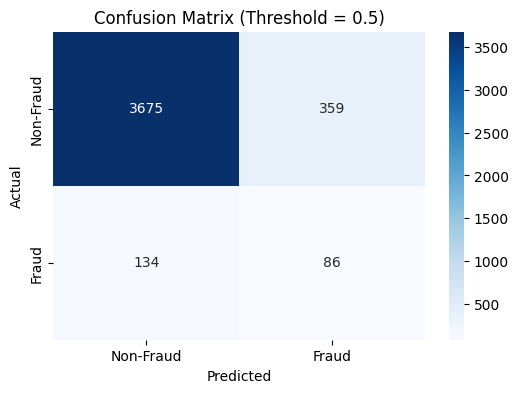


AUC Score: 0.72


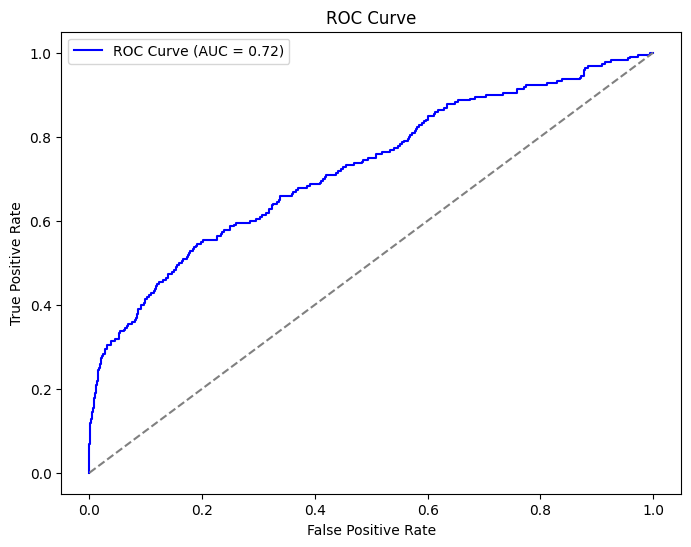

In [ ]:
# Initialize the model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
# Train the model
log_reg.fit(X_train, y_train)

# Make predictions and get probabilities on the validation set
y_pred = log_reg.predict(X_val)
y_proba = log_reg.predict_proba(X_val)[:, 1]  # For AUC calculation

# Evaluate with multiple thresholds
thresholds = [0.5]
for threshold in thresholds:
    print(f"\n--- Threshold = {threshold} ---")

    # Make predictions based on the current threshold
    y_pred_thresh = (y_proba >= threshold).astype(int)

    # Classification report for the current threshold
    print("Classification Report:")
    print(classification_report(y_val, y_pred_thresh))

    # Confusion Matrix for the current threshold
    conf_matrix = confusion_matrix(y_val, y_pred_thresh)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (Threshold = {threshold})')
    plt.show()

# Overall AUC score (independent of threshold)
auc_score = roc_auc_score(y_val, y_proba)
print(f"\nAUC Score: {auc_score:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_val, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## All Models


In [ ]:
# Initialize the 9 different models to run and evaluate
# Setting max_depth=3 for all gradient boosting algorithms
log_reg = LogisticRegression(random_state=42, max_iter=1000)
ada_model = AdaBoostClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42, max_depth=3)
lgb_model = lgb.LGBMClassifier(random_state=42, max_depth=3, verbose=-1)
catboost_model = CatBoostClassifier(random_state=42, max_depth=3, verbose=0)
mlp_model = MLPClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42, max_depth=3)
rf_model = RandomForestClassifier(random_state=42)
gnb_model = GaussianNB()

models = {
    "Logistic Regression": log_reg,
    "AdaBoost Classifier": ada_model,
    "Gradient Boosting Classifier": gb_model,
    "LGBM Classifier": lgb_model,
    "CatBoost Classifier": catboost_model,
    "MLP Classifier": mlp_model,
    "XGB Classifier": xgb_model,
    "Random Forest Classifier": rf_model,
    "GaussianNB": gnb_model
}

# Define thresholds to evaluate
thresholds = [0.5]

# Initialize a list to hold evaluation results
results = []

# Train each model and evaluate with multiple thresholds
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Get prediction probabilities
    y_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class

    for threshold in thresholds:
        # Apply threshold to get binary predictions
        y_pred_thresh = (y_proba >= threshold).astype(int)

        # Calculate metrics for the current threshold
        accuracy = accuracy_score(y_val, y_pred_thresh)
        precision = precision_score(y_val, y_pred_thresh)
        recall = recall_score(y_val, y_pred_thresh)
        f1 = f1_score(y_val, y_pred_thresh)
        auc = roc_auc_score(y_val, y_proba)  # AUC is independent of the threshold

        # Append the results for the current model and threshold
        results.append({
            "Model Name": model_name,
            "Threshold": threshold,
            "Accuracy": accuracy,
            "Recall": recall,
            "Precision": precision,
            "F1-Score": f1,
            "AUC": auc
        })

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Display the full DataFrame
print("Complete Results:")
print(results_df)

Complete Results:
                     Model Name  Threshold  Accuracy    Recall  Precision  \
0           Logistic Regression        0.5  0.884109  0.390909   0.193258   
1           AdaBoost Classifier        0.5  0.919840  0.450000   0.310345   
2  Gradient Boosting Classifier        0.5  0.928538  0.431818   0.346715   
3               LGBM Classifier        0.5  0.930654  0.413636   0.354086   
4           CatBoost Classifier        0.5  0.936530  0.404545   0.390351   
5                MLP Classifier        0.5  0.892337  0.422727   0.219340   
6                XGB Classifier        0.5  0.929478  0.400000   0.343750   
7      Random Forest Classifier        0.5  0.925247  0.413636   0.325000   
8                    GaussianNB        0.5  0.910202  0.290909   0.220690   

   F1-Score       AUC  
0  0.258647  0.724381  
1  0.367347  0.794257  
2  0.384615  0.822184  
3  0.381551  0.820491  
4  0.397321  0.820746  
5  0.288820  0.737759  
6  0.369748  0.813187  
7  0.364000  0.8191

In [ ]:
# Initialize the 9 different models to run and evaluate
# Setting max_depth=3 for all gradient boosting algorithms
log_reg = LogisticRegression(random_state=42, max_iter=1000)
ada_model = AdaBoostClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42, max_depth=3)
lgb_model = lgb.LGBMClassifier(random_state=42, max_depth=3, verbose=-1)
catboost_model = CatBoostClassifier(random_state=42, max_depth=3, verbose=0)
mlp_model = MLPClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42, max_depth=3)
rf_model = RandomForestClassifier(random_state=42)
gnb_model = GaussianNB()

models = {
    # "Logistic Regression": log_reg,
    # "AdaBoost Classifier": ada_model,
    # "Gradient Boosting Classifier": gb_model,
    # "LGBM Classifier": lgb_model
    # "CatBoost Classifier": catboost_model
    # "MLP Classifier": mlp_model,
    # "XGB Classifier": xgb_model
    "Random Forest Classifier": rf_model
    # "GaussianNB": gnb_model
}

# Define thresholds to evaluate
thresholds = [0.1,0.2,0.3,0.4,0.5]

# Initialize a list to hold evaluation results
results = []

# Train each model and evaluate with multiple thresholds
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Get prediction probabilities
    y_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class

    for threshold in thresholds:
        # Apply threshold to get binary predictions
        y_pred_thresh = (y_proba >= threshold).astype(int)

        # Calculate metrics for the current threshold
        accuracy = accuracy_score(y_val, y_pred_thresh)
        precision = precision_score(y_val, y_pred_thresh)
        recall = recall_score(y_val, y_pred_thresh)
        f1 = f1_score(y_val, y_pred_thresh)
        auc = roc_auc_score(y_val, y_proba)  # AUC is independent of the threshold

        # Append the results for the current model and threshold
        results.append({
            "Model Name": model_name,
            "Threshold": threshold,
            "Accuracy": accuracy,
            "Recall": recall,
            "Precision": precision,
            "F1-Score": f1,
            "AUC": auc
        })

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Display the full DataFrame
print("Complete Results:")
print(results_df)

Complete Results:
                 Model Name  Threshold  Accuracy    Recall  Precision  \
0  Random Forest Classifier        0.1  0.404325  0.904545   0.073378   
1  Random Forest Classifier        0.2  0.701457  0.804545   0.126068   
2  Random Forest Classifier        0.3  0.829807  0.659091   0.182620   
3  Random Forest Classifier        0.4  0.893512  0.527273   0.249462   
4  Random Forest Classifier        0.5  0.925247  0.413636   0.325000   

   F1-Score       AUC  
0  0.135744  0.819137  
1  0.217980  0.819137  
2  0.285996  0.819137  
3  0.338686  0.819137  
4  0.364000  0.819137  


In [ ]:
# Get top 5 models based on AUC score
top_5_models = results_df.sort_values('AUC', ascending=False).head(5)
print("Top 5 Models by AUC:")
print(top_5_models[['Model Name', 'AUC']])

Top 5 Models by AUC:
                     Model Name       AUC
2  Gradient Boosting Classifier  0.822184
4           CatBoost Classifier  0.820746
3               LGBM Classifier  0.820491
7      Random Forest Classifier  0.819137
6                XGB Classifier  0.813187


# Hyper Parameter Tuning


## Adjusted by F1

In [ ]:
# Do Grid search on top 5 models (Gradient Boosting, LGBM, Random Forest) F1 score based

def perform_grid_search(X_train, y_train, X_val, y_val, cv=5):
    """
    Perform grid search for Random Forest, LGBM, and MLP models

    Parameters:
    -----------
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    X_val : array-like
        val features
    y_val : array-like
        val labels
    cv : int
        Number of cross-validation folds
    """

    # Define scoring metrics
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score),
        'auc': make_scorer(roc_auc_score)
    }

    # Random Forest parameters
    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    # LGBM parameters
    lgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, -1],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 62, 127],
        'min_child_samples': [20, 50, 100],
        'subsample': [0.8, 0.9, 1.0]
    }

    # Gradient Boosting parameters
    gb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.8, 0.9, 1.0]
    }

    # CatBoost parameters
    catboost_param_grid = {
        'iterations': [100, 200, 300],
        'depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'l2_leaf_reg': [1, 3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }

    # XGBoost parameters
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }


    # Initialize models
    models = {
        'Random Forest': (RandomForestClassifier(random_state=42), rf_param_grid),
        'LGBM': (lgb.LGBMClassifier(random_state=42), lgb_param_grid),
        'Gradient Boosting': (GradientBoostingClassifier(random_state=42), gb_param_grid),
        'CatBoost': (CatBoostClassifier(random_state=42, verbose=0), catboost_param_grid),
        'XGBoost': (xgb.XGBClassifier(random_state=42), xgb_param_grid)
    }

    results = {}

    # Perform grid search for each model
    for model_name, (model, param_grid) in models.items():
        print(f"\nPerforming grid search for {model_name}...")

        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            scoring=scoring,
            refit='f1',  # Optimize for F1 score
            n_jobs=-1,   # Use all available cores
            verbose=1,
            return_train_score=True
        )

        # Fit the grid search
        grid_search.fit(X_train, y_train)

        # Get best parameters and scores
        results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'best_estimator': grid_search.best_estimator_
        }

        # Evaluate on val set
        best_model = grid_search.best_estimator_
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]
        y_pred = best_model.predict(X_val)

        # Calculate metrics
        val_metrics = {
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred),
            'recall': recall_score(y_val, y_pred),
            'f1': f1_score(y_val, y_pred),
            'auc': roc_auc_score(y_val, y_pred_proba)
        }

        results[model_name]['val_metrics'] = val_metrics

        # Print results
        print(f"\nBest parameters for {model_name}:")
        print(results[model_name]['best_params'])
        print(f"\nval set metrics for {model_name}:")
        for metric, value in val_metrics.items():
            print(f"{metric}: {value:.4f}")

    return results

In [ ]:
results = perform_grid_search(X_train, y_train, X_val, y_val)
print(results)


Performing grid search for Random Forest...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters for Random Forest:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

val set metrics for Random Forest:
accuracy: 0.9309
precision: 0.3588
recall: 0.4273
f1: 0.3900
auc: 0.8211

Performing grid search for LGBM...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Best parameters for LGBM:
{'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 127, 'subsample': 0.8}

val set metrics for LGBM:
accuracy: 0.9278
precision: 0.3333
recall: 0.3955
f1: 0.3617
auc: 0.7925

Performing grid search for Gradient Boosting...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Best parameters for Gradient Boosting:
{'learning_rate': 0.05, 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}

val set metrics for Gradien

In [ ]:
# Do Grid search on top 5 models (CatBoost, XGB)

def perform_grid_search(X_train, y_train, X_val, y_val, cv=5):
    """
    Perform grid search for Random Forest, LGBM, and MLP models

    Parameters:
    -----------
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    X_val : array-like
        val features
    y_val : array-like
        val labels
    cv : int
        Number of cross-validation folds
    """

    # Define scoring metrics
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score),
        'auc': make_scorer(roc_auc_score)
    }

    # CatBoost parameters
    catboost_param_grid = {
        'iterations': [100, 200, 300],
        'depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'l2_leaf_reg': [1, 3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }

    # XGBoost parameters
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }


    # Initialize models
    models = {
        'CatBoost': (CatBoostClassifier(random_state=42, verbose=0), catboost_param_grid),
        'XGBoost': (xgb.XGBClassifier(random_state=42), xgb_param_grid)
    }

    results = {}

    # Perform grid search for each model
    for model_name, (model, param_grid) in models.items():
        print(f"\nPerforming grid search for {model_name}...")

        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            scoring=scoring,
            refit='f1',  # Optimize for F1 score
            n_jobs=-1,   # Use all available cores
            verbose=1,
            return_train_score=True
        )

        # Fit the grid search
        grid_search.fit(X_train, y_train)

        # Get best parameters and scores
        results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'best_estimator': grid_search.best_estimator_
        }

        # Evaluate on val set
        best_model = grid_search.best_estimator_
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]
        y_pred = best_model.predict(X_val)

        # Calculate metrics
        val_metrics = {
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred),
            'recall': recall_score(y_val, y_pred),
            'f1': f1_score(y_val, y_pred),
            'auc': roc_auc_score(y_val, y_pred_proba)
        }

        results[model_name]['val_metrics'] = val_metrics

        # Print results
        print(f"\nBest parameters for {model_name}:")
        print(results[model_name]['best_params'])
        print(f"\nval set metrics for {model_name}:")
        for metric, value in val_metrics.items():
            print(f"{metric}: {value:.4f}")

    return results

results = perform_grid_search(X_train, y_train, X_val, y_val)
print(results)


Performing grid search for CatBoost...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best parameters for CatBoost:
{'depth': 7, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.05, 'subsample': 0.8}

val set metrics for CatBoost:
accuracy: 0.9346
precision: 0.3849
recall: 0.4409
f1: 0.4110
auc: 0.8173

Performing grid search for XGBoost...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits

Best parameters for XGBoost:
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}

val set metrics for XGBoost:
accuracy: 0.9264
precision: 0.3232
recall: 0.3864
f1: 0.3520
auc: 0.7982
{'CatBoost': {'best_params': {'depth': 7, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.05, 'subsample': 0.8}, 'best_score': 0.764458399094519, 'best_estimator': <catboost.core.CatBoostClassifier object at 0x7e48e79b86d0>, 'val_metrics': {'accuracy': 0.9346497414198401, 'precision': 0.38492063492

## Adjusted by AUC

In [ ]:
#Hyperparameter tuning with grid search, AUC score based
def perform_grid_search(X_train, y_train, X_val, y_val, cv=5):
    """
    Perform grid search for Random Forest, LGBM, and Gradient Boosting models, optimizing for AUC score.

    Parameters:
    -----------
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    X_val : array-like
        Validation features
    y_val : array-like
        Validation labels
    cv : int
        Number of cross-validation folds
    """

    # Random Forest parameters
    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    # LGBM parameters
    lgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, -1],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 62, 127],
        'min_child_samples': [20, 50, 100],
        'subsample': [0.8, 0.9, 1.0]
    }

    # Gradient Boosting parameters
    gb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.8, 0.9, 1.0]
    }

    # CatBoost parameters
    catboost_param_grid = {
        'iterations': [100, 200, 300],
        'depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'l2_leaf_reg': [1, 3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }

    # XGBoost parameters
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    # Initialize models
    models = {
        'Random Forest': (RandomForestClassifier(random_state=42), rf_param_grid),
        'LGBM': (lgb.LGBMClassifier(random_state=42), lgb_param_grid),
        'Gradient Boosting': (GradientBoostingClassifier(random_state=42), gb_param_grid),
        'CatBoost': (CatBoostClassifier(random_state=42, verbose=0), catboost_param_grid),
        'XGBoost': (xgb.XGBClassifier(random_state=42), xgb_param_grid)
    }

    results = {}

    # Perform grid search for each model
    for model_name, (model, param_grid) in models.items():
        print(f"\nPerforming grid search for {model_name}...")

        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            scoring='roc_auc',  # Optimize for AUC score
            refit='roc_auc',    # Refit based on AUC score
            n_jobs=-1,          # Use all available cores
            verbose=1,
            return_train_score=True
        )

        # Fit the grid search
        grid_search.fit(X_train, y_train)

        # Get best parameters and scores
        results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'best_estimator': grid_search.best_estimator_
        }

        # Evaluate on val set
        best_model = grid_search.best_estimator_
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]
        y_pred = best_model.predict(X_val)

        # Calculate metrics
        val_metrics = {
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred),
            'recall': recall_score(y_val, y_pred),
            'f1': f1_score(y_val, y_pred),
            'auc': roc_auc_score(y_val, y_pred_proba)
        }

        results[model_name]['val_metrics'] = val_metrics

        # Print results
        print(f"\nBest parameters for {model_name}:")
        print(results[model_name]['best_params'])
        print(f"\nval set metrics for {model_name}:")
        for metric, value in val_metrics.items():
            print(f"{metric}: {value:.4f}")

    return results

In [ ]:
results = perform_grid_search(X_train, y_train, X_val, y_val)
print(results)


Performing grid search for Random Forest...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters for Random Forest:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

val set metrics for Random Forest:
accuracy: 0.9309
precision: 0.3588
recall: 0.4273
f1: 0.3900
auc: 0.8211

Performing grid search for LGBM...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Best parameters for LGBM:
{'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 127, 'subsample': 0.8}

val set metrics for LGBM:
accuracy: 0.9278
precision: 0.3333
recall: 0.3955
f1: 0.3617
auc: 0.7925

Performing grid search for Gradient Boosting...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Best parameters for Gradient Boosting:
{'learning_rate': 0.05, 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}

val set metrics for Gradien

# Testing Tuned Models with Threshold (Using results fron AUC Run)

In [ ]:
rf_model = RandomForestClassifier(max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42)
lgbm_model = lgb.LGBMClassifier(learning_rate=0.1, max_depth=-1, min_child_samples=20, n_estimators=200, num_leaves=127, subsample=0.8, random_state=42)
gb_model = GradientBoostingClassifier(learning_rate=0.05, max_depth=7, min_samples_split=2, n_estimators=300, subsample=0.8, random_state=42)
catboost_model = CatBoostClassifier(depth=7, iterations=300, l2_leaf_reg=1, learning_rate=0.05, subsample=0.9, random_state=42, verbose=0)
xgb_model = xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8, random_state=42)

# Combine all models in a dictionary for iteration
models = {
    "Random Forest Classifier": rf_model,
    "LGBM Classifier": lgbm_model,
    "Gradient Boosting Classifier": gb_model,
    "CatBoost Classifier": catboost_model,
    "XGB Classifier": xgb_model,
}

# Define thresholds to evaluate
thresholds = [0.1,0.2,0.3,0.4,0.5]

# Initialize a list to hold evaluation results
results = []

# Train each model and evaluate with multiple thresholds
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Get prediction probabilities
    y_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class

    for threshold in thresholds:
        # Apply threshold to get binary predictions
        y_pred_thresh = (y_proba >= threshold).astype(int)

        # Calculate metrics for the current threshold
        accuracy = accuracy_score(y_val, y_pred_thresh)
        precision = precision_score(y_val, y_pred_thresh)
        recall = recall_score(y_val, y_pred_thresh)
        f1 = f1_score(y_val, y_pred_thresh)
        auc = roc_auc_score(y_val, y_proba)  # AUC is independent of the threshold

        # Append the results for the current model and threshold
        results.append({
            "Model Name": model_name,
            "Threshold": threshold,
            "Accuracy": accuracy,
            "Recall": recall,
            "Precision": precision,
            "F1-Score": f1,
            "AUC": auc
        })

# Create a DataFrame from results
results_df = pd.DataFrame(results)

print(results_df)
# Filter results based on recall > 0.8 and f1 > 0.1
filtered_results = results_df[(results_df['Recall'] > 0.8) & (results_df['F1-Score'] > 0.1)]

# Display the filtered results
print("Models with Recall > 0.8 and F1-Score > 0.1:")
print(filtered_results[['Model Name', 'Threshold', 'Recall', 'Accuracy', 'Precision', 'F1-Score']])


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2200, number of negative: 4400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3044
[LightGBM] [Info] Number of data points in the train set: 6600, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
                      Model Name  Threshold  Accuracy    Recall  Precision  \
0       Random Forest Classifier        0.1  0.423131  0.895455   0.074962   
1       Random Forest Classifier        0.2  0.714151  0.790909   0.129464   
2       Random Forest Classifier        0.3  0.842031  0.650000   0.193767   
3       Random Forest Classifier        0.4  0.899389

In [ ]:
X_final_trained = np.vstack([X_train, X_val])  # Combine val and train features
y_final_trained = np.hstack([y_train, y_val])  # Combine val and train labels

catboost_model = CatBoostClassifier(depth=7, iterations=300, l2_leaf_reg=5, learning_rate=0.05, subsample=0.8, random_state=42, verbose=0)
rf_model = RandomForestClassifier(max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42)
xgb_model = xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8, random_state=42)

# Define a function to evaluate the model and return metrics based on a threshold
def evaluate_model_at_threshold(model, X_train, y_train, X_test, y_test, threshold=0.1):
    # Train the model
    model.fit(X_train, y_train)

    # Get predicted probabilities
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    # Apply threshold to predicted probabilities
    y_test_pred = (y_test_pred_proba >= threshold).astype(int)

    # Calculate metrics
    def get_metrics(y_true, y_pred, y_pred_proba):
        return {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'auc': roc_auc_score(y_true, y_pred_proba)
        }

    # Return metrics for test set
    return get_metrics(y_test, y_test_pred, y_test_pred_proba)

# List of models to train and evaluate
models = {
    'Random Forest': rf_model,
    "XGB Classifier": xgb_model,
    'CatBoost': catboost_model
}

# Prepare to collect all metrics for comparison
all_metrics = {}

# Loop over each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}...\n")

    # Train and evaluate on X_train and X_val, and then on X_final_trained and X_test with threshold of 0.1
    print(f"Training {model_name} on X_train and evaluating on X_val...")
    train_metrics = evaluate_model_at_threshold(model, X_train, y_train, X_val, y_val, threshold=0.1)

    print(f"Training {model_name} on X_final_trained and evaluating on X_test...\n")
    final_train_metrics = evaluate_model_at_threshold(model, X_final_trained, y_final_trained, X_test, y_test, threshold=0.1)

    # Store results for comparison
    all_metrics[model_name] = {
        'Train (X_train) vs Final Train (X_final_trained)': {
            'accuracy': [train_metrics['accuracy'], final_train_metrics['accuracy']],
            'precision': [train_metrics['precision'], final_train_metrics['precision']],
            'recall': [train_metrics['recall'], final_train_metrics['recall']],
            'f1': [train_metrics['f1'], final_train_metrics['f1']],
            'auc': [train_metrics['auc'], final_train_metrics['auc']]
        }
    }



Evaluating Random Forest...

Training Random Forest on X_train and evaluating on X_val...
Training Random Forest on X_final_trained and evaluating on X_test...

Evaluating XGB Classifier...

Training XGB Classifier on X_train and evaluating on X_val...
Training XGB Classifier on X_final_trained and evaluating on X_test...

Evaluating CatBoost...

Training CatBoost on X_train and evaluating on X_val...
Training CatBoost on X_final_trained and evaluating on X_test...



# Final Results

In [ ]:
# Print comparison results for all models
print("\nComparison of metrics for all models (at threshold 0.1):\n")
for model_name, metrics in all_metrics.items():
    print(f"Model: {model_name}")
    for metric, values in metrics['Train (X_train) vs Final Train (X_final_trained)'].items():
        print(f"{metric}: Train (X_train) = {values[0]:.4f} | Final Train (X_final_trained) = {values[1]:.4f}")
    print("-" * 60)


Comparison of metrics for all models (at threshold 0.1):

Model: Random Forest
accuracy: Train (X_train) = 0.4231 | Final Train (X_final_trained) = 0.6011
precision: Train (X_train) = 0.0750 | Final Train (X_final_trained) = 0.0995
recall: Train (X_train) = 0.8955 | Final Train (X_final_trained) = 0.8361
f1: Train (X_train) = 0.1383 | Final Train (X_final_trained) = 0.1779
auc: Train (X_train) = 0.8211 | Final Train (X_final_trained) = 0.8238
------------------------------------------------------------
Model: XGB Classifier
accuracy: Train (X_train) = 0.6584 | Final Train (X_final_trained) = 0.7377
precision: Train (X_train) = 0.1125 | Final Train (X_final_trained) = 0.1327
recall: Train (X_train) = 0.8136 | Final Train (X_final_trained) = 0.7377
f1: Train (X_train) = 0.1977 | Final Train (X_final_trained) = 0.2250
auc: Train (X_train) = 0.8090 | Final Train (X_final_trained) = 0.8180
------------------------------------------------------------
Model: CatBoost
accuracy: Train (X_train

# Ensembling (Extra)

In [ ]:
def evaluate_stacking_model(model, X_train, y_train, X_val, y_val, threshold=0.1):
    model.fit(X_train, y_train)

    # Predictions on validation set
    y_val_proba = model.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_proba >= threshold).astype(int)  # Apply custom threshold

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_val, y_val_pred),
        'precision': precision_score(y_val, y_val_pred),
        'recall': recall_score(y_val, y_val_pred),
        'f1': f1_score(y_val, y_val_pred),
        'auc': roc_auc_score(y_val, y_val_proba)
    }
    return metrics

# Define the models for stacking
models_combinations = [
    [('rf', rf_model), ('xgb', xgb_model)],  # Random Forest + XGBoost
    [('rf', rf_model), ('catboost', catboost_model)],  # Random Forest + CatBoost
    [('catboost', catboost_model), ('xgb', xgb_model)],  # CatBoost + XGBoost
    [('rf', rf_model), ('xgb', xgb_model), ('catboost', catboost_model)],  # All three models
]

# Initialize results dictionary
stacking_results = {}

# Iterate over different combinations
for i, base_models in enumerate(models_combinations, 1):
    print(f"Evaluating stacking ensemble {i} with models: {[name for name, _ in base_models]}")

    # Define Stacking Classifier with Logistic Regression as the meta-model
    stacking_model = StackingClassifier(
        estimators=base_models,
        final_estimator=LogisticRegression(random_state=42, class_weight='balanced'),  # Class weight prioritizes recall
        passthrough=False  # Set to True if you want to include original features in final model
    )

    # Evaluate the stacking model, using a lower threshold for recall prioritization
    metrics = evaluate_stacking_model(stacking_model, X_train, y_train, X_val, y_val, threshold=0.3)

    # Save results
    stacking_results[f"Stacking Ensemble {i}"] = metrics

    # Print results
    print(f"Metrics for Stacking Ensemble {i}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print("-" * 60)

# Display overall results
print("\nFinal Results for all Stacking Ensembles:")
for ensemble, metrics in stacking_results.items():
    print(f"{ensemble}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print("-" * 60)


Evaluating stacking ensemble 1 with models: ['rf', 'xgb']
Metrics for Stacking Ensemble 1:
accuracy: 0.8126
precision: 0.1703
recall: 0.6773
f1: 0.2721
auc: 0.8206
------------------------------------------------------------
Evaluating stacking ensemble 2 with models: ['rf', 'catboost']
Metrics for Stacking Ensemble 2:
accuracy: 0.8131
precision: 0.1737
recall: 0.6955
f1: 0.2779
auc: 0.8223
------------------------------------------------------------
Evaluating stacking ensemble 3 with models: ['catboost', 'xgb']
Metrics for Stacking Ensemble 3:
accuracy: 0.8197
precision: 0.1725
recall: 0.6545
f1: 0.2730
auc: 0.8136
------------------------------------------------------------
Evaluating stacking ensemble 4 with models: ['rf', 'xgb', 'catboost']
Metrics for Stacking Ensemble 4:
accuracy: 0.8131
precision: 0.1707
recall: 0.6773
f1: 0.2726
auc: 0.8210
------------------------------------------------------------

Final Results for all Stacking Ensembles:
Stacking Ensemble 1:
accuracy: 0.8